In [2]:
import nltk
import re
import pandas as pd
import numpy
import csv
import string
from nltk.corpus import stopwords
import pickle

try:
    stop_words = set(stopwords.words("english"))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words("english"))


# Loading Data

In [3]:
data = pd.read_csv("London_hotel_reviews.csv", encoding='ISO-8859-1')
import chardet

In [4]:
with open("London_hotel_reviews.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [5]:
data.head(20)

,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review
0,Apex London Wall Hotel,5,Ottima qualità prezzo,Siamo stati a Londra per un week end ed abbiam...,"Casale Monferrato, Italy",10/20/2012
1,Corinthia Hotel London,5,"By far, my best hotel in the world",I had a pleasure of staying in this hotel for ...,"Savannah, Georgia",3/23/2016
2,The Savoy,5,First visit to the American Bar at the Savoy,A very lovely first visit to this iconic hotel...,London,7/30/2013
3,Rhodes Hotel,4,Nice stay,3 of us stayed at the Rhodes Hotel for 4 night...,"Maui, Hawaii",6/2/2012
4,The Savoy,5,Perfection,Form the moment we arrived until we left we ex...,"London, United Kingdom",11/24/2017
5,Corinthia Hotel London,1,Staff stole from me!!,Well I am no strange to London's 5star hotels ...,NaN,3/1/2013
6,Apex London Wall Hotel,5,Great customer service and comfy bed,"The hotel staff were very helpful, I booked th...","Lostwithiel, United Kingdom",10/22/2017
7,Mondrian London at Sea Containers,5,"Yes, it's really good!",Already stepping out of the taxi you get that ...,Stockholm,12/16/2014
8,Mondrian London at Sea Containers,5,Incredible,What an incredibly cool place. Had the most de...,"London, England, United Kingdom",3/5/2016
9,Rhodes Hotel,5,Ottima scelta!,"Ottimo rapporto qualità - prezzo, ottima la po...",Cagliari,2/7/2011


In [6]:
data1 = data.copy()

#  Cleaning the data to make it more easy to process

# Convert text to lower case

In [7]:
data1["Property Name"] = data["Property Name"].apply(lambda x: x.lower() if type(x) == str else x)
data1["Review Title"] = data["Review Title"].apply(lambda x: x.lower() if type(x) == str else x)
data1["Review Text"] = data["Review Text"].apply(lambda x: x.lower() if type(x) == str else x)
data1["Location Of The Reviewer"] = data["Location Of The Reviewer"].apply(lambda x: x.lower() if type(x) == str else x)

In [8]:

#Removing unwanted text like u+....
for i in data1.index:
    row = str(data1.loc[i, 'Review Text'])
    #row = re.sub(r'[\W_]+', '', row)
    #row = re.sub(r'\W', '', row, flags=re.UNICODE)
    row = re.sub(r'([<]*[u+a-z|0-9]*[>])|(\||!|\.|\,)', '', row)
    data1.loc[i, 'Review Text'] = row
#data2.head(10)

In [9]:
data1['Review Text'][440]

'      bar boulud    '

# Tokenize Text

In [10]:
from nltk.tokenize import word_tokenize as wd
def tokenize(line):
    word = wd(line)
    return word

In [11]:
try:
    data1["Property Name"] = data1["Property Name"].apply(lambda x: tokenize(x) if type(x) == str else x)
    data1["Review Title"] = data1["Review Title"].apply(lambda x: tokenize(x) if type(x) == str else x)
    data1["Review Text"] = data1["Review Text"].apply(lambda x: tokenize(x) if type(x) == str else x)
    data1["Location Of The Reviewer"] = data1["Location Of The Reviewer"].apply(lambda x: tokenize(x) if type(x) == str else x)
except LookupError:
    nltk.download('punkt')
    data1["Property Name"] = data1["Property Name"].apply(lambda x: tokenize(x) if type(x) == str else x)
    data1["Review Title"] = data1["Review Title"].apply(lambda x: tokenize(x) if type(x) == str else x)
    data1["Review Text"] = data1["Review Text"].apply(lambda x: tokenize(x) if type(x) == str else x)
    data1["Location Of The Reviewer"] = data1["Location Of The Reviewer"].apply(lambda x: tokenize(x) if type(x) == str else x)

In [12]:
#Removing Empty rows
for i in data1.index:
    row = data1.loc[i, 'Review Text']
    if (row==""):
        data1.drop([i])

In [13]:
data2 = data1.copy()

# Further Cleaning: Removing Punctuation and stopwords

In [14]:
def remove_punctuation(column_name):
    all_sentences = []
    for i in data2.index:
        my_sentence = []
        custom_stopwords=["a","'s","..."," 's", "'m ","i ",",","\t"]
        
        pr=data2.loc[i, column_name]
        if(type(pr) != float):
            for item in pr:
                if(item not in string.punctuation):
                    if (item not in stop_words):
                        if(item not in custom_stopwords):
                            my_sentence.append(item)
        final_sentence = " ".join(my_sentence)
        all_sentences.append(final_sentence)
        
    return all_sentences


In [15]:
all_sentence = remove_punctuation("Review Text")
data2["Review Text"] = all_sentence
all_sentence = remove_punctuation("Property Name")
data2["Property Name"] = all_sentence
all_sentence = remove_punctuation("Review Title")
data2["Review Title"] = all_sentence
all_sentence = remove_punctuation("Location Of The Reviewer")
data2["Location Of The Reviewer"] = all_sentence

# Saving cleaned data as csv

In [16]:
data2.to_csv(path_or_buf="./clean_data.csv")

# Loading Data Processed by SentiStrength

In [17]:
data2["Review Text"].to_csv(path_or_buf="./review.txt", sep="\t", index=None,header=False)

In [18]:
data_sentiment = pd.read_csv("Review_with_sentiment.csv")

# Calculating Overall Sentiment & storing in separate dataframe

In [19]:
def calculate_overall_sentiment(df):
    overall_sentiment = []
    for i in df.index:
        positive = int(df["Positive"][i])
        negative = int(df["Negative"][i])
        overall = positive + negative
        overall_sentiment.append(overall)
    return overall_sentiment
        

In [20]:
data2["Positive"] = data_sentiment["Positive"]
data2["Negative"] = data_sentiment["Negative"]

In [21]:
df_correlation = data2.drop(labels="Property Name",axis="columns")
df_correlation = df_correlation.drop(labels="Review Text",axis="columns")
df_correlation = df_correlation.drop(labels="Location Of The Reviewer",axis="columns")
df_correlation = df_correlation.drop(labels="Date Of Review",axis="columns")
df_correlation = df_correlation.drop(labels="Review Title",axis="columns")
overall_sentiment = calculate_overall_sentiment(df_correlation)
df_correlation["Overall Sentiment"] = overall_sentiment

In [22]:
D1 = data2.copy()

In [23]:
D1["Positive"] = data_sentiment["Positive"]
D1["Negative"] = data_sentiment["Negative"]
D1["Overall Sentiment"] = df_correlation["Overall Sentiment"]

# Saving D1 with positive, negative and overall sentiment values

In [24]:
D1.to_csv('./D1.csv')

# Calculating Pearson Correlation Coefficient

In [25]:
df_correlation.corr(method='pearson')

,Review Rating,Positive,Negative,Overall Sentiment
Review Rating,1.000000,0.256865,0.330641,0.417469
Positive,0.256865,1.000000,-0.021256,0.728032
Negative,0.330641,-0.021256,1.000000,0.669913
Overall Sentiment,0.417469,0.728032,0.669913,1.000000


# Calculating First order statistics (Mean) of reviews grouped by hotels

In [26]:
data2.groupby(['Property Name']).mean()

,Review Rating,Positive,Negative
Property Name,,,
45 park lane dorchester collection,4.752577,3.211340,-1.706186
apex london wall hotel,4.694785,3.058957,-1.610884
bulgari hotel london,4.710359,3.019027,-1.608879
city view hotel,1.611111,2.500000,-2.555556
corinthia hotel london,4.789007,3.219858,-1.731206
dorchester,4.624419,3.135465,-1.825581
hartley hotel,1.568182,2.045455,-2.727273
hotel xenia autograph collection,4.523622,3.042651,-1.595144
lanesborough,4.808642,3.074074,-1.583333


# Calculating Second order statistics (Standard Deviation) of reviews grouped by hotels

In [27]:
data2.groupby(['Property Name']).std()

,Review Rating,Positive,Negative
Property Name,,,
45 park lane dorchester collection,0.558141,0.911456,0.827796
apex london wall hotel,0.579282,0.901284,0.766275
bulgari hotel london,0.700059,0.932952,0.831889
city view hotel,0.777544,0.785905,1.149026
corinthia hotel london,0.634656,0.870405,0.827913
dorchester,0.810552,0.886666,0.870188
hartley hotel,0.899554,0.913835,1.207797
hotel xenia autograph collection,0.751514,0.947827,0.752847
lanesborough,0.619937,0.967302,0.784427


# Selecting STD threshold at 75% for ambigous class

In [28]:
max_values = data2.groupby(['Property Name']).std().max()
max_std = max_values["Review Rating"]
std_threshold = max_std * 0.75 
print(std_threshold)

1.0927929486281602


In [29]:
high_std = data2.groupby(['Property Name']).std()
high_std = high_std.drop(['Positive', 'Negative'], axis=1)
high_std = high_std['Review Rating'] > std_threshold
high_std

Property Name
45 park lane dorchester collection                        False
apex london wall hotel                                    False
bulgari hotel london                                      False
city view hotel                                           False
corinthia hotel london                                    False
dorchester                                                False
hartley hotel                                             False
hotel xenia autograph collection                          False
lanesborough                                              False
london guest house                                        False
mandarin oriental hyde park london                        False
marble arch hotel                                          True
mondrian london sea containers                            False
newham hotel                                               True
rembrandt                                                 False
rhodes hotel              

In [30]:
hotel_list = ['newham hotel', 'marble arch hotel', 'z hotel']

In [31]:
def assign_ambigous(hotel_list, df):
    for i in df.index:
        if(df['Property Name'][i] in hotel_list):
            df.loc[i, 'Ambigous'] = "Yes"
            #df["Ambigous"][i] = 'Yes'
        else:
            df.loc[i, 'Ambigous'] = "Not Ambigous"
            #df["Ambigous"][i] = 'Not Ambigous'

In [32]:
data_with_ambiguity = data2.copy()
#Creating Empty Colum called Ambigous
data_with_ambiguity['Ambigous'] = ""

In [33]:
assign_ambigous(hotel_list,data_with_ambiguity)

# Adding 'Ambigous' attribute to the database D1

In [34]:
D1["Ambigous"] = data_with_ambiguity["Ambigous"]

# Saving changes and writing to database D1

In [35]:
D1.to_csv('./D1.csv')

In [36]:
D1.head(30)

,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review,Positive,Negative,Overall Sentiment,Ambigous
0,apex london wall hotel,5,ottima qualità prezzo,siamo stati londra per un week end ed abbiamo ...,casale monferrato italy,10/20/2012,3,-2,1,Not Ambigous
1,corinthia hotel london,5,far best hotel world,pleasure staying hotel 7 nights recently hotel...,savannah georgia,3/23/2016,3,-1,2,Not Ambigous
2,savoy,5,first visit american bar savoy,lovely first visit iconic hotel bar wonderful ...,london,7/30/2013,3,-2,1,Not Ambigous
3,rhodes hotel,4,nice stay,3 us stayed rhodes hotel 4 nights great locati...,maui hawaii,6/2/2012,3,-2,1,Not Ambigous
4,savoy,5,perfection,form moment arrived left experienced absolute ...,london united kingdom,11/24/2017,3,-1,2,Not Ambigous
5,corinthia hotel london,1,staff stole,well strange london 5star hotels new one comes...,,3/1/2013,3,-3,0,Not Ambigous
6,apex london wall hotel,5,great customer service comfy bed,hotel staff helpful booked wrong hotel mistake...,lostwithiel united kingdom,10/22/2017,3,-2,1,Not Ambigous
7,mondrian london sea containers,5,yes really good,already stepping taxi get special feeling welc...,stockholm,12/16/2014,4,-2,2,Not Ambigous
8,mondrian london sea containers,5,incredible,incredibly cool place delicious interesting co...,london england united kingdom,3/5/2016,4,-1,3,Not Ambigous
9,rhodes hotel,5,ottima scelta,ottimo rapporto qualità prezzo ottima la posiz...,cagliari,2/7/2011,1,-2,-1,Not Ambigous


## DataFrame with only reviews of hotels belonging to Ambigous Class

In [37]:
#DataFrame with only data of hotels with standard deviation above threshold
filtered_data = D1.copy()
filtered_data = filtered_data.loc[(filtered_data['Property Name'] == 'z hotel') | (filtered_data['Property Name'] == 'marble arch hotel') | (filtered_data['Property Name'] == 'newham hotel')]

In [38]:
filtered_data.head(50)

,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review,Positive,Negative,Overall Sentiment,Ambigous
23,z hotel,5,excellent rapport qualité prix,15 mn à pied 5 en bus passage fréquent de la s...,paris france,1/5/2016,2,-2,0,Yes
105,z hotel,2,minimo indispensabile,un letto un bagno un tettopunto non bisogna av...,treviso italy,11/21/2015,1,-1,0,Yes
188,marble arch hotel,3,,try best negative points rooms small tv rooms ...,london united kingdom,11/11/2017,3,-2,1,Yes
285,newham hotel,4,great stay budget,hotel great place stay budget rooms clean comf...,manchester united kingdom,5/26/2018,3,-2,1,Yes
302,newham hotel,2,great,great dirty poorly maintained judging breakfas...,,8/19/2018,3,-2,1,Yes
323,z hotel,3,ok hotel forhold til prisen,hvis man vælger et hotel som dette så skal man...,risskov denmark,6/4/2013,1,-1,0,Yes
396,newham hotel,1,daughters 18th birthday,overall room acceptable basic clean however he...,,1/20/2016,3,-2,1,Yes
495,marble arch hotel,5,gorgeous tea afternoon,mariela alicia treated us really well hotel sp...,,12/5/2017,3,-2,1,Yes
516,z hotel,2,filthy unhygienic,hotel good value money filthy unhygienic worki...,london united kingdom,2/16/2016,2,-2,0,Yes
635,z hotel,1,blanker horror,dieses haus müsste geschlossen werdenhaare amp...,dortmund germany,7/28/2014,1,-2,-1,Yes


In [39]:
def classify_ambigous(hotel_name, data):
    sentiment_score = 0
    #Calculating the overall sentiment for one specific hotel
    for review in data.index:
        if(data['Property Name'][review] == hotel_name):
            sentiment_score += data['Overall Sentiment'][review]
    
    #Classifying the ambigous class hotel to either positive or negative.
    for i in data.index:
        if(data['Property Name'][i] == hotel_name):
            if(sentiment_score > 0):
                data.loc[i, 'Ambigous'] = 1
            else:
                data.loc[i, 'Ambigous'] = -1
                
        
    

In [40]:
classify_ambigous('z hotel', filtered_data)
classify_ambigous('marble arch hotel', filtered_data)
classify_ambigous('newham hotel', filtered_data)

# Generate Histogram

In [41]:
import matplotlib as plt
%matplotlib inline

In [42]:
#filtered_data.hist(column='Property Name', by=None)

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>],
       [<AxesSubplot:title={'center':'5'}>, <AxesSubplot:>]], dtype=object)

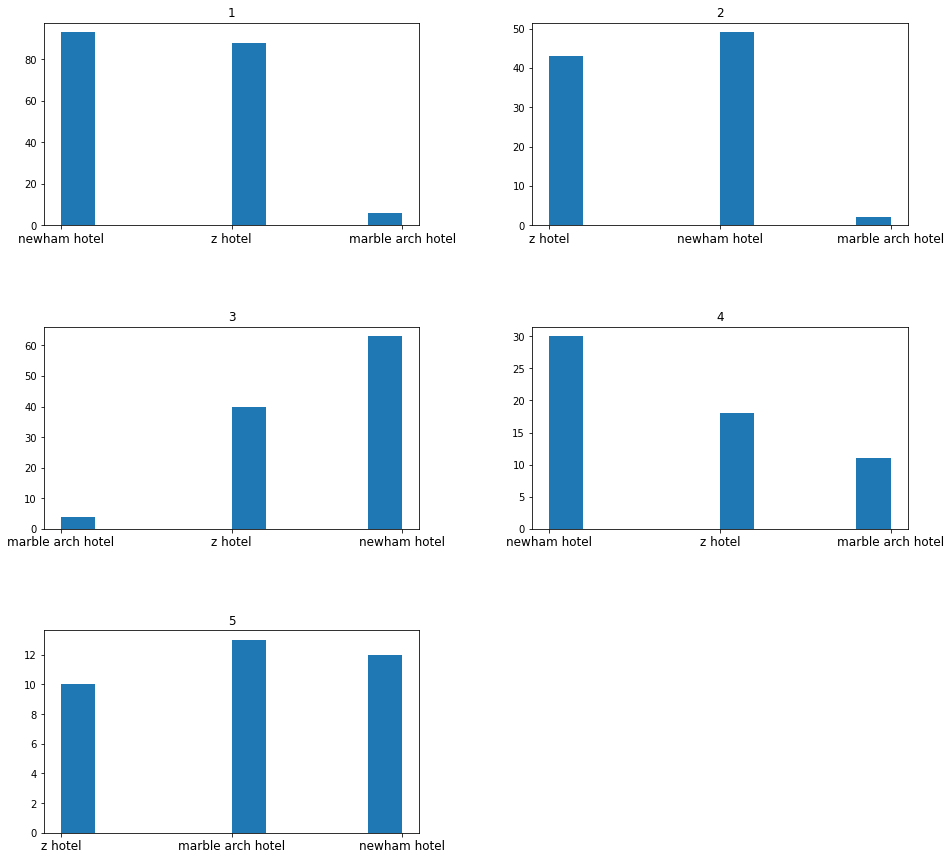

In [43]:
#data2.plot.hist(by='Review Rating', bins=15)
filtered_data.hist(column='Property Name', by='Review Rating', figsize=(15,15), xrot=0, xlabelsize=12)


<AxesSubplot:>

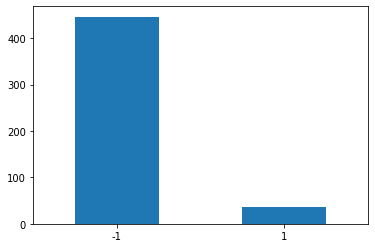

In [44]:
filtered_data['Ambigous'].value_counts().plot.bar(rot=0)

In [45]:
def concatenate_content(data):
    positive_doc = []
    negative_doc = []
    for i in data.index:
        row = data.loc[i, 'Ambigous']
        text = data.loc[i, 'Review Text']
        if(row == 1):
            positive_doc.append(text)
        else:
            negative_doc.append(text)
    return positive_doc, negative_doc

In [46]:
positive, negative = concatenate_content(filtered_data)

In [47]:
positive_concat = " ".join(positive)
negative_concat = " ".join(negative)

In [48]:
type(positive_concat)

str

In [49]:
# from wordcloud import WordCloud, STOPWORDS 
# import matplotlib.pyplot as plt 
# import pandas as pd 
  
# # Reads 'Youtube04-Eminem.csv' file  
# #df = pd.read_csv(r"Youtube04-Eminem.csv", encoding ="latin-1") 
  
# comment_words = '' 
# stopwords = set(STOPWORDS) 
  
# # iterate through the csv file 
# for val in df.CONTENT: 
      
#     # typecaste each val to string 
#     val = str(val) 
  
#     # split the value 
#     tokens = val.split() 
#     # Converts each token into lowercase 
#     for i in range(len(tokens)): 
#         tokens[i] = tokens[i].lower() 
      
#     comment_words += " ".join(tokens)+" "
  
# wordcloud = WordCloud(width = 800, height = 800, 
#                 background_color ='white', 
#                 stopwords = stopwords, 
#                 min_font_size = 10).generate(comment_words) 
  
# # plot the WordCloud image                        
# plt.figure(figsize = (8, 8), facecolor = None) 
# plt.imshow(wordcloud) 
# plt.axis("off") 
# plt.tight_layout(pad = 0) 
  
# plt.show()

In [50]:
print(positive_concat)

try best negative points rooms small tv rooms really small cabs outside hotel nightporter needed cab positive points nespresso machine room really friendly water room try best little touches room like wallpaper art next elevator amazing location quiet peacefull still central safe welcoming place mariela alicia treated us really well hotel spectacular food lovely great time def come back price bit expensive side hotel really worth really close marble arch husband stayed hotel anniversary 3 nights staff polite helpful arrived bit earlier scheduled check helpful put luggage aside us finally get room lovely box chocolates us note manager nice touch room small typical room england europe matter bathroom good size fabulous soaker tub tv built fantastic tv actually shower area decor room classic tasteful hotel general location great well fairly close places far enough hustle bustle city hotel pricier side get london overall fantastic time would highly recommend hotel couples hotel expected bo

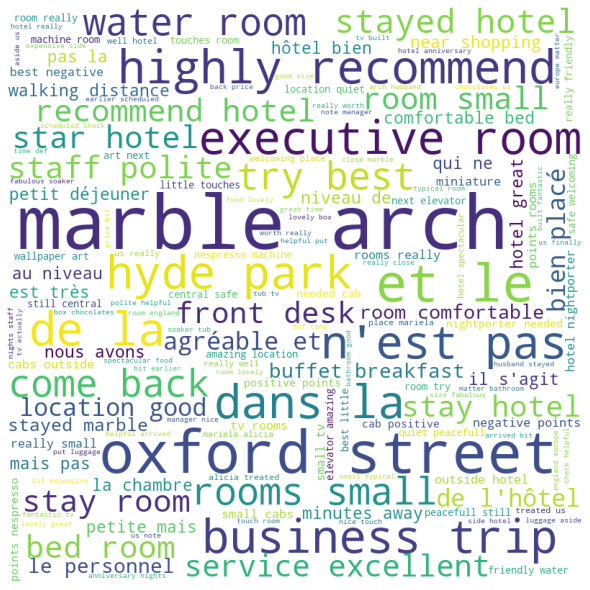

In [51]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
comment_words = '' 
stopwords = set(STOPWORDS)
tokens = tokenize(str(positive_concat))
for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

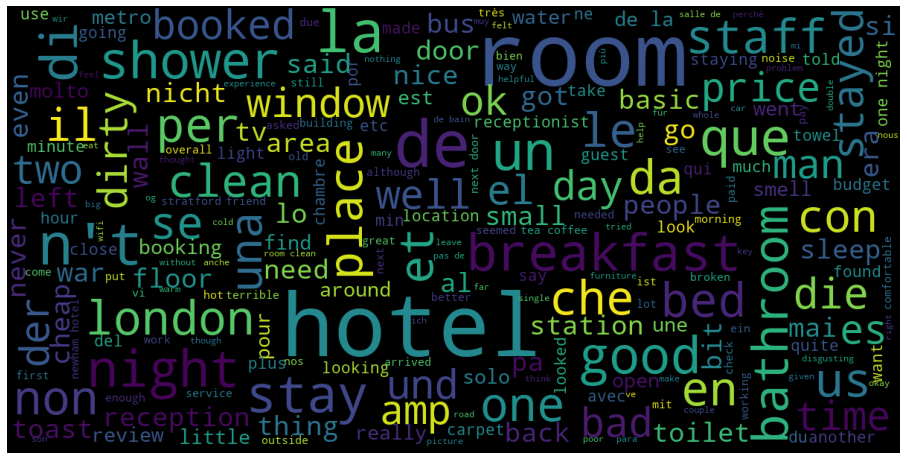

In [52]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=400,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(16, 16))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(negative_concat)

In [53]:

negative_comments=tokenize(negative_concat)

In [54]:
import gensim
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
stemmer=SnowballStemmer("english")

In [55]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for sample in text:
        stem = []
        tokenized=tokenize(sample)
        for token in tokenized:
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
                stem.append(lemmatize_stemming(token))
        result.append(stem)
    return result

In [56]:
try:
    positive_stemmed=preprocess(positive)
    negative_stemmed=preprocess(negative)
except LookupError:
    nltk.download('wordnet')
    positive_stemmed=preprocess(positive)
    negative_stemmed=preprocess(negative)

[nltk_data] Downloading package wordnet to /home/mitja/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [57]:
dictionary_positive = gensim.corpora.Dictionary(positive_stemmed)
dictionary_negative = gensim.corpora.Dictionary(negative_stemmed)

In [58]:
bow_corpus_positive = [dictionary_positive.doc2bow(doc) for doc in positive_stemmed]
bow_corpus_negative = [dictionary_negative.doc2bow(doc) for doc in negative_stemmed]

In [59]:
from gensim import corpora, models
tfidf_positive = models.TfidfModel(bow_corpus_positive)
tfidf_negative = models.TfidfModel(bow_corpus_negative)

#corpus_tfidf_positive = tfidf[bow_corpus_positive]
#corpus_tfidf_negative = tfidf[bow_corpus_negative]
# Fixed this since tfidf is not defined -Mitja
corpus_tfidf_positive = tfidf_positive
corpus_tfidf_negative = tfidf_negative

In [60]:
lda_model_positive = gensim.models.LdaMulticore(bow_corpus_positive, num_topics=5, id2word=dictionary_positive, passes=2, workers=2)
lda_model_negative = gensim.models.LdaMulticore(bow_corpus_negative, num_topics=5, id2word=dictionary_negative, passes=2, workers=2)

In [61]:
#print(lda_model[bow_corpus[0]])
# lda_model is not defined
# 

In [62]:
for idx, topic in lda_model_positive.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.016*"room" + 0.012*"hotel" + 0.012*"good" + 0.011*"mai" + 0.010*"london" + 0.010*"dan" + 0.009*"petit" + 0.007*"breakfast" + 0.007*"nice" + 0.007*"avec"
Topic: 1 
Words: 0.023*"room" + 0.010*"close" + 0.010*"includ" + 0.009*"arriv" + 0.009*"suppos" + 0.008*"hotel" + 0.006*"london" + 0.006*"comfort" + 0.006*"stay" + 0.006*"breakfast"
Topic: 2 
Words: 0.040*"room" + 0.016*"hotel" + 0.014*"stay" + 0.012*"like" + 0.011*"small" + 0.009*"think" + 0.009*"staff" + 0.008*"ask" + 0.008*"nice" + 0.007*"tell"
Topic: 3 
Words: 0.025*"hotel" + 0.015*"servic" + 0.014*"room" + 0.014*"stay" + 0.013*"friend" + 0.010*"breakfast" + 0.010*"busi" + 0.009*"staff" + 0.008*"good" + 0.008*"help"
Topic: 4 
Words: 0.039*"hotel" + 0.034*"room" + 0.020*"stay" + 0.010*"small" + 0.010*"like" + 0.009*"good" + 0.009*"great" + 0.008*"love" + 0.008*"servic" + 0.008*"complain"


In [63]:
for idx, topic in lda_model_negative.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.018*"hotel" + 0.017*"room" + 0.008*"stay" + 0.007*"shower" + 0.005*"book" + 0.005*"breakfast" + 0.005*"bathroom" + 0.004*"night" + 0.004*"leav" + 0.003*"work"
Topic: 1 
Words: 0.011*"hotel" + 0.008*"room" + 0.006*"pour" + 0.005*"dan" + 0.005*"stay" + 0.005*"chambr" + 0.004*"avec" + 0.004*"nous" + 0.003*"good" + 0.003*"london"
Topic: 2 
Words: 0.024*"room" + 0.014*"hotel" + 0.010*"stay" + 0.007*"night" + 0.006*"good" + 0.005*"breakfast" + 0.005*"clean" + 0.005*"book" + 0.004*"sleep" + 0.004*"like"
Topic: 3 
Words: 0.012*"hotel" + 0.007*"room" + 0.005*"breakfast" + 0.004*"stay" + 0.004*"colazion" + 0.003*"dirti" + 0.003*"molto" + 0.003*"solo" + 0.003*"night" + 0.003*"good"
Topic: 4 
Words: 0.031*"room" + 0.027*"hotel" + 0.012*"stay" + 0.012*"breakfast" + 0.012*"night" + 0.008*"staff" + 0.008*"clean" + 0.008*"good" + 0.007*"place" + 0.007*"bathroom"


In [96]:
# Task 7
from empath import Empath

lexicon = Empath()

# analyze positive dict
topics = lda_model_positive.show_topics()
positive_topics = []
for topic in topics:
    # find words and add to list
    words = re.compile('[A-Za-z]+').findall(topic[1])
    positive_topics.extend(words)
# create string from list and analyze it with empath
positive_topics_str = " ".join(positive_topics)
positive_dict = lexicon.analyze(positive_topics_str)
nonzero_positive_dict = positive_dict.copy()
# Remove zero value categories
for key, value in positive_dict.items():
    if value == 0:
        del nonzero_positive_dict[key]
print(nonzero_positive_dict)


['room', 'hotel', 'good', 'mai', 'london', 'dan', 'petit', 'breakfast', 'nice', 'avec', 'room', 'close', 'includ', 'arriv', 'suppos', 'hotel', 'london', 'comfort', 'stay', 'breakfast', 'room', 'hotel', 'stay', 'like', 'small', 'think', 'staff', 'ask', 'nice', 'tell', 'hotel', 'servic', 'room', 'stay', 'friend', 'breakfast', 'busi', 'staff', 'good', 'help', 'hotel', 'room', 'stay', 'small', 'like', 'good', 'great', 'love', 'servic', 'complain']
{'help': 2.0, 'office': 7.0, 'sleep': 6.0, 'vacation': 9.0, 'dispute': 1.0, 'tourism': 5.0, 'furniture': 5.0, 'morning': 3.0, 'optimism': 1.0, 'home': 5.0, 'childish': 1.0, 'cooking': 3.0, 'eating': 3.0, 'restaurant': 3.0, 'love': 1.0, 'communication': 2.0, 'order': 1.0, 'air_travel': 5.0, 'politeness': 2.0, 'speaking': 2.0, 'affection': 1.0, 'traveling': 9.0, 'shape_and_size': 2.0, 'party': 1.0, 'friends': 4.0, 'achievement': 1.0, 'positive_emotion': 4.0}


In [92]:
# analyze negative dict
topics = lda_model_negative.show_topics()
negative_topics = []
for topic in topics:
    # find words and add to list
    words = re.compile('[A-Za-z]+').findall(topic[1])
    negative_topics.extend(words)
# create string from list and analyze it with empath
negative_topics_str = " ".join(negative_topics)
negative_dict = lexicon.analyze(negative_topics_str)
nonzero_negative_dict = negative_dict.copy()
# Remove zero value categories
for key, value in negative_dict.items():
    if value == 0:
        del nonzero_negative_dict[key]
print(nonzero_negative_dict)


{'office': 6.0, 'dance': 1.0, 'domestic_work': 4.0, 'sleep': 6.0, 'vacation': 14.0, 'tourism': 5.0, 'furniture': 5.0, 'morning': 4.0, 'night': 5.0, 'home': 7.0, 'business': 1.0, 'cooking': 4.0, 'reading': 2.0, 'eating': 4.0, 'restaurant': 4.0, 'hygiene': 5.0, 'air_travel': 5.0, 'music': 1.0, 'work': 1.0, 'traveling': 10.0, 'cleaning': 5.0, 'alcohol': 1.0, 'liquid': 1.0, 'writing': 2.0, 'musical': 1.0}


In [93]:
# TODO Add findings to Database 1 after task6 is reported there

In [94]:
#Task 8

# Count overlapping ratio
positive_empath_categories = len(nonzero_positive_dict)
negative_empath_categories = len(nonzero_negative_dict)
all_empath_categories = len(positive_dict)

overlapping_ratio = round((positive_empath_categories + negative_empath_categories) / all_empath_categories, 5)
print("Overlapping ratio: " + str(overlapping_ratio))

Overlapping ratio: 0.26804


In [105]:
#Task 9

total_topics = []
total_topics.extend(positive_topics)
total_topics.extend(negative_topics)
# remove duplicate topics
total_topics_cleaned = list(set(total_topics))
print(total_topics_cleaned)
print("\nLDA has a total of {} unique topics".format(len(total_topics_cleaned)))


['like', 'leav', 'pour', 'nous', 'ask', 'busi', 'work', 'sleep', 'solo', 'chambr', 'close', 'help', 'clean', 'dan', 'hotel', 'petit', 'small', 'friend', 'complain', 'bathroom', 'place', 'molto', 'suppos', 'arriv', 'great', 'good', 'includ', 'servic', 'think', 'avec', 'colazion', 'breakfast', 'london', 'nice', 'room', 'comfort', 'shower', 'book', 'tell', 'staff', 'stay', 'love', 'mai', 'dirti', 'night']

LDA has a total of 45 unique topics


In [109]:
# Create list of all Empath pre-built categories
empath_categories = []
for key, value in positive_dict.items():
    empath_categories.append(key)
print(empath_categories)

In [110]:
# Calculate agreement between empath categories and LDA
common_categories = 0
for category in total_topics_cleaned:
    if category in empath_categories:
        common_categories = common_categories + 1
print("LDA and empath have {} common categories".format(common_categories))


LDA and empath have 5 common categories


In [112]:
# Calculate overlapping ratio
overlapping_ratio2 = round(common_categories/len(total_topics_cleaned), 5)
print("Overlapping ratio 2 : " + str(overlapping_ratio2))

Overlapping ratio 2 : 0.11111
